In [1]:
!pip install torchinfo

In [2]:
!pip install gdown

In [3]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
import numpy as np
from tqdm import tqdm

import itertools
from torchinfo import summary
import matplotlib.pyplot as plt

import os

In [4]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# 모델 가중치 저장 경로 설정
model_weight_path = "./model_weights.pth"

In [5]:
class ConvNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super(ConvNorm, self).__init__()
        self.linear = nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=stride, padding=padding, bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.linear(x)
        x = self.bn(x)
        return x

In [6]:
class Stem16(nn.Module):
    def __init__(self):
        super(Stem16, self).__init__()
        self.conv1 = ConvNorm(3, 32)
        self.act1 = nn.Hardswish()
        self.conv2 = ConvNorm(32, 64)
        self.act2 = nn.Hardswish()
        self.conv3 = ConvNorm(64, 128)
        self.act3 = nn.Hardswish()
        self.conv4 = ConvNorm(128, 256)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.conv4(x)
        return x

In [7]:
class LinearNorm(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearNorm, self).__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
        self.bn = nn.BatchNorm1d(out_features)

    def forward(self, x):

        if x.dim() == 3:
            B, N, C = x.shape
            x = x.reshape(B * N, C)
            x = self.bn(self.linear(x))
            x = x.reshape(B, N, -1)
        else:
            x = self.bn(self.linear(x))
        return x

In [8]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads, attn_ratio=2):
        super(Attention, self).__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5
        inner_dim = head_dim * num_heads * 3
        self.qkv = LinearNorm(dim, inner_dim)

        self.proj = nn.Sequential(
            nn.Hardswish(),
            LinearNorm(dim, dim)
        )

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x)
        qkv = qkv.view(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        return self.proj(x)

In [9]:
class LevitMlp(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super(LevitMlp, self).__init__()
        self.ln1 = LinearNorm(in_features, hidden_features)
        self.act = nn.Hardswish()
        self.drop = nn.Dropout(p=0.5, inplace=False)#dropout 적용
        self.ln2 = LinearNorm(hidden_features, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.ln2(x)
        return x

In [10]:
class LevitBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=2):
        super(LevitBlock, self).__init__()
        self.attn = Attention(dim, num_heads)
        self.drop_path1 = nn.Identity()
        self.mlp = LevitMlp(dim, dim * mlp_ratio, dim)
        self.drop_path2 = nn.Identity()

    def forward(self, x):
        x = x + self.drop_path1(self.attn(x))
        x = x + self.drop_path2(self.mlp(x))
        return x

In [11]:
# class AttentionDownsample(nn.Module):
#     def __init__(self, dim, out_dim, num_heads, attn_ratio=2):
#         super(AttentionDownsample, self).__init__()
#         self.num_heads = num_heads
#         self.scale = (dim // num_heads) ** -0.5
#         inner_dim = dim * attn_ratio * num_heads
#         self.kv = LinearNorm(dim, inner_dim)

#         self.q = nn.Sequential(
#             nn.Conv2d(dim, dim, kernel_size=2, stride=2),
#             nn.Flatten(start_dim=1)
#         )

#         self.proj = nn.Sequential(
#             nn.Hardswish(),
#             LinearNorm(dim, out_dim)
#         )

#     def forward(self, x):
#         B, N, C = x.shape
#         H = W = int(N ** 0.5)
#         x = x.reshape(B, C, H, W)

#         kv = self.kv(x.flatten(2).transpose(1, 2))
#         q = self.q(x)

#         q = q.reshape(B, -1, C)
#         x = self.proj(q)
#         return x

In [12]:
# class LevitDownsample(nn.Module):
#     def __init__(self, dim, out_dim, num_heads, attn_ratio=2):
#         super(LevitDownsample, self).__init__()
#         self.attn_downsample = AttentionDownsample(dim, out_dim, num_heads, attn_ratio)
#         self.mlp = LevitMlp(out_dim, out_dim * attn_ratio, out_dim)
#         self.drop_path = nn.Identity()

#     def forward(self, x):
#         x = self.attn_downsample(x)
#         x = self.drop_path(self.mlp(x))
#         return x

In [13]:
#CNNDownSample 적용
class CNNDownsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(CNNDownsample, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.act = nn.Hardswish()

    def forward(self, x):
        # print(x.shape)
        B, N, C = x.shape # (B, N, C)  N=H*W (16 * 16 = 196)
        H = int(np.sqrt(N))
        x = x.view(B, H, H, C).permute(0, 3, 1, 2)
        x = self.conv(x)
        x = self.act(x)
        x = x.permute(0, 2, 3, 1).view(B, -1, self.out_channels)
        return x

In [14]:
class LevitStage(nn.Module):
    def __init__(self, dim, out_dim, num_heads, num_blocks, downsample=True):
        super(LevitStage, self).__init__()
        self.downsample = CNNDownsample(dim, out_dim) if downsample else nn.Identity()
        self.blocks = nn.Sequential(*[LevitBlock(out_dim, num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        x = self.downsample(x)
        x = self.blocks(x)
        return x

In [15]:
class ConvLevitStage(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, kernel_size, stride, padding):
        super(ConvLevitStage, self).__init__()
        self.layers = nn.Sequential(
            *[nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding)
              for i in range(num_blocks)],
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.layers(x)

In [16]:
class NormLinear(nn.Module):
    def __init__(self, in_features, out_features, dropout_prob=0.5):#drop_out_0.5 적용
        super(NormLinear, self).__init__()
        self.bn = nn.BatchNorm1d(in_features)
        self.drop = nn.Dropout(p=dropout_prob, inplace=False)
        self.linear = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x):
        x = self.bn(x)
        x = self.drop(x)
        x = self.linear(x)
        return x


In [17]:
class LevitDistilled(nn.Module):
    def __init__(self, num_classes=100):
        super(LevitDistilled, self).__init__()

        self.stem = Stem16()

        self.stage1 = LevitStage(dim=256, out_dim=256, num_heads=4, num_blocks=2, downsample=False) # block 수 적용
        self.stage2 = LevitStage(dim=256, out_dim=384, num_heads=6, num_blocks=2, downsample=True)

        self.conv1x1 = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.head = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)
        self.head_dist = NormLinear(in_features=512, out_features=num_classes, dropout_prob=0.0)

    def forward(self, x):
        x = self.stem(x)

        B, C, H, W = x.shape
        x = x.view(B, C, -1).transpose(1, 2)
        x = self.stage1(x)
        x = self.stage2(x)

        H = W = int(x.shape[1]**0.5)
        x = x.transpose(1, 2).view(B, 384, H, W)

        x = self.conv1x1(x)

        x = torch.mean(x, dim=(2, 3))
        out = self.head(x)
        out_dist = self.head_dist(x)
        return out

In [18]:
model = LevitDistilled()
# model = LauncherModel()
print(model)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

batch_size = 32
learning_rate = 1e-4
num_epochs = 100

LevitDistilled(
  (stem): Stem16(
    (conv1): ConvNorm(
      (linear): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act1): Hardswish()
    (conv2): ConvNorm(
      (linear): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act2): Hardswish()
    (conv3): ConvNorm(
      (linear): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act3): Hardswish()
    (conv4): ConvNorm(
      (linear): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stage1): LevitStage(
  

In [19]:
print(summary(model, input_size=(32, 3, 224, 224)))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 100]                 --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─ConvNorm: 2-1                                    [32, 32, 112, 112]        --
│    │    └─Conv2d: 3-1                                 [32, 32, 112, 112]        864
│    │    └─BatchNorm2d: 3-2                            [32, 32, 112, 112]        64
│    └─Hardswish: 2-2                                   [32, 32, 112, 112]        --
│    └─ConvNorm: 2-3                                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-3                                 [32, 64, 56, 56]          18,432
│    │    └─BatchNorm2d: 3-4                            [32, 64, 56, 56]          128
│    └─Hardswish: 2-4                                   [32, 64, 56, 56]          --
│    └─ConvNorm: 2-5                                  

In [20]:
print(summary(model, input_size=(32, 3, 224, 224), verbose=2))

Layer (type:depth-idx)                                  Output Shape              Param #
LevitDistilled                                          [32, 100]                 --
├─Stem16: 1-1                                           [32, 256, 14, 14]         --
│    └─conv1.linear.weight                                                        ├─864
│    └─conv1.bn.weight                                                            ├─32
│    └─conv1.bn.bias                                                              ├─32
│    └─conv2.linear.weight                                                        ├─18,432
│    └─conv2.bn.weight                                                            ├─64
│    └─conv2.bn.bias                                                              ├─64
│    └─conv3.linear.weight                                                        ├─73,728
│    └─conv3.bn.weight                                                            ├─128
│    └─conv3.bn.bias              

In [21]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [22]:
train_data = datasets.CIFAR100(root="data", train=True, transform=transform, download=True)
test_data = datasets.CIFAR100(root="data", train=False, transform=transform, download=True)
combined_data = ConcatDataset([train_data, test_data])

train_size = int(0.7 * len(combined_data))
val_size = int(0.15 * len(combined_data))
test_size = len(combined_data) - train_size - val_size
train_data, val_data, test_data = random_split(combined_data, [train_size, val_size, test_size])

100%|██████████| 169M/169M [00:13<00:00, 12.7MB/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [23]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_data)}")
print(f"Validation size: {len(val_data)}")
print(f"Test size: {len(test_data)}")

Train size: 42000
Validation size: 9000
Test size: 9000


In [24]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

In [25]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(accuracy)
    print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy:.2f}%")

In [26]:
def evaluate(model, data_loader, criterion, device, phase="Validation"):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc=f"{phase}"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total
    if phase == "Validation":
        val_losses.append(epoch_loss)
        val_accuracies.append(accuracy)
    print(f"{phase} Loss: {epoch_loss:.4f}, {phase} Accuracy: {accuracy:.2f}%")

In [27]:
def measure_inference_time(model, data_loader, device):
    model.eval()
    times = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            start_time = torch.cuda.Event(enable_timing=True)
            end_time = torch.cuda.Event(enable_timing=True)

            start_time.record()
            _ = model(inputs)  # inference 수행
            end_time.record()

            # 시간 측정
            torch.cuda.synchronize()  # CUDA에서 모든 커널이 완료될 때까지 대기
            elapsed_time = start_time.elapsed_time(end_time)  # 밀리초 단위로 반환
            times.append(elapsed_time)

    # 통계량 계산
    times_np = np.array(times)
    total_inferences = len(times_np)
    avg_time = np.mean(times_np)
    std_dev = np.std(times_np)
    max_time = np.max(times_np)
    min_time = np.min(times_np)

    # 결과 출력
    print(f"Inference Time Measurement Results:")
    print(f"Total Inferences: {total_inferences}")
    print(f"Average Time: {avg_time:.2f} ms")
    print(f"Standard Deviation: {std_dev:.2f} ms")
    print(f"Maximum Time: {max_time:.2f} ms")
    print(f"Minimum Time: {min_time:.2f} ms")

    return times

In [28]:
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train(model, train_loader, criterion, optimizer, device)
    evaluate(model, val_loader, criterion, device, phase="Validation")
    val_loss = val_losses[-1]  # Assuming `val_losses` is updated in `evaluate`
    scheduler.step()
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.8f}")


Epoch 1/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.04it/s]


Train Loss: 4.1470, Train Accuracy: 7.39%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.89it/s]


Validation Loss: 3.7435, Validation Accuracy: 11.50%
Learning Rate: 0.00999013

Epoch 2/100


Training: 100%|██████████| 1313/1313 [01:31<00:00, 14.28it/s]


Train Loss: 3.5706, Train Accuracy: 14.93%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 3.4285, Validation Accuracy: 16.90%
Learning Rate: 0.00996057

Epoch 3/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.25it/s]


Train Loss: 3.3345, Train Accuracy: 19.33%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.91it/s]


Validation Loss: 3.3328, Validation Accuracy: 17.88%
Learning Rate: 0.00991144

Epoch 4/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 3.1847, Train Accuracy: 22.31%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.72it/s]


Validation Loss: 3.1285, Validation Accuracy: 24.26%
Learning Rate: 0.00984292

Epoch 5/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.24it/s]


Train Loss: 3.0563, Train Accuracy: 24.64%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 3.0028, Validation Accuracy: 25.89%
Learning Rate: 0.00975528

Epoch 6/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.21it/s]


Train Loss: 2.9017, Train Accuracy: 27.41%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.72it/s]


Validation Loss: 2.7991, Validation Accuracy: 29.83%
Learning Rate: 0.00964888

Epoch 7/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.21it/s]


Train Loss: 2.7709, Train Accuracy: 30.12%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.79it/s]


Validation Loss: 2.6997, Validation Accuracy: 31.16%
Learning Rate: 0.00952414

Epoch 8/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.17it/s]


Train Loss: 2.6467, Train Accuracy: 32.80%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.92it/s]


Validation Loss: 2.6360, Validation Accuracy: 32.73%
Learning Rate: 0.00938153

Epoch 9/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.19it/s]


Train Loss: 2.5301, Train Accuracy: 34.77%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.90it/s]


Validation Loss: 2.5924, Validation Accuracy: 33.92%
Learning Rate: 0.00922164

Epoch 10/100


Training: 100%|██████████| 1313/1313 [01:31<00:00, 14.29it/s]


Train Loss: 2.4320, Train Accuracy: 37.08%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.70it/s]


Validation Loss: 2.4707, Validation Accuracy: 36.53%
Learning Rate: 0.00904508

Epoch 11/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.19it/s]


Train Loss: 2.3384, Train Accuracy: 38.88%


Validation: 100%|██████████| 282/282 [00:15<00:00, 18.01it/s]


Validation Loss: 2.4198, Validation Accuracy: 37.49%
Learning Rate: 0.00885257

Epoch 12/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.18it/s]


Train Loss: 2.2555, Train Accuracy: 40.80%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.93it/s]


Validation Loss: 2.4285, Validation Accuracy: 37.19%
Learning Rate: 0.00864484

Epoch 13/100


Training: 100%|██████████| 1313/1313 [01:31<00:00, 14.28it/s]


Train Loss: 2.1749, Train Accuracy: 42.55%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.81it/s]


Validation Loss: 2.2725, Validation Accuracy: 40.54%
Learning Rate: 0.00842274

Epoch 14/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.22it/s]


Train Loss: 2.1064, Train Accuracy: 44.20%


Validation: 100%|██████████| 282/282 [00:15<00:00, 18.08it/s]


Validation Loss: 2.3139, Validation Accuracy: 40.34%
Learning Rate: 0.00818712

Epoch 15/100


Training: 100%|██████████| 1313/1313 [01:31<00:00, 14.27it/s]


Train Loss: 2.0325, Train Accuracy: 45.53%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.79it/s]


Validation Loss: 2.2018, Validation Accuracy: 42.06%
Learning Rate: 0.00793893

Epoch 16/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.25it/s]


Train Loss: 1.9594, Train Accuracy: 47.05%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.81it/s]


Validation Loss: 2.2085, Validation Accuracy: 43.03%
Learning Rate: 0.00767913

Epoch 17/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 1.8835, Train Accuracy: 48.77%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.87it/s]


Validation Loss: 2.1746, Validation Accuracy: 43.26%
Learning Rate: 0.00740877

Epoch 18/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.17it/s]


Train Loss: 1.8136, Train Accuracy: 50.74%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.72it/s]


Validation Loss: 2.1536, Validation Accuracy: 43.77%
Learning Rate: 0.00712890

Epoch 19/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.20it/s]


Train Loss: 1.7479, Train Accuracy: 51.92%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.81it/s]


Validation Loss: 2.1202, Validation Accuracy: 44.42%
Learning Rate: 0.00684062

Epoch 20/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.21it/s]


Train Loss: 1.6758, Train Accuracy: 53.37%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.79it/s]


Validation Loss: 2.1171, Validation Accuracy: 45.44%
Learning Rate: 0.00654508

Epoch 21/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 1.6090, Train Accuracy: 55.22%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.82it/s]


Validation Loss: 2.1186, Validation Accuracy: 45.37%
Learning Rate: 0.00624345

Epoch 22/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 1.5474, Train Accuracy: 56.85%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.95it/s]


Validation Loss: 2.0924, Validation Accuracy: 46.71%
Learning Rate: 0.00593691

Epoch 23/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 1.4783, Train Accuracy: 58.33%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.73it/s]


Validation Loss: 2.1265, Validation Accuracy: 46.40%
Learning Rate: 0.00562667

Epoch 24/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 1.4195, Train Accuracy: 59.73%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.95it/s]


Validation Loss: 2.1082, Validation Accuracy: 46.73%
Learning Rate: 0.00531395

Epoch 25/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 1.3518, Train Accuracy: 61.37%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.76it/s]


Validation Loss: 2.0762, Validation Accuracy: 48.04%
Learning Rate: 0.00500000

Epoch 26/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 1.2871, Train Accuracy: 63.04%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.86it/s]


Validation Loss: 2.0804, Validation Accuracy: 48.02%
Learning Rate: 0.00468605

Epoch 27/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.24it/s]


Train Loss: 1.2297, Train Accuracy: 64.54%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.76it/s]


Validation Loss: 2.1480, Validation Accuracy: 47.34%
Learning Rate: 0.00437333

Epoch 28/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.19it/s]


Train Loss: 1.1647, Train Accuracy: 65.97%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.1580, Validation Accuracy: 47.84%
Learning Rate: 0.00406309

Epoch 29/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 1.1089, Train Accuracy: 67.37%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.77it/s]


Validation Loss: 2.1751, Validation Accuracy: 48.87%
Learning Rate: 0.00375655

Epoch 30/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 1.0495, Train Accuracy: 68.92%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.72it/s]


Validation Loss: 2.1686, Validation Accuracy: 48.46%
Learning Rate: 0.00345492

Epoch 31/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 0.9964, Train Accuracy: 70.33%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.76it/s]


Validation Loss: 2.1975, Validation Accuracy: 49.33%
Learning Rate: 0.00315938

Epoch 32/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 0.9305, Train Accuracy: 72.39%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.88it/s]


Validation Loss: 2.2320, Validation Accuracy: 48.90%
Learning Rate: 0.00287110

Epoch 33/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 0.8784, Train Accuracy: 73.51%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.90it/s]


Validation Loss: 2.2691, Validation Accuracy: 49.01%
Learning Rate: 0.00259123

Epoch 34/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 0.8226, Train Accuracy: 75.16%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.96it/s]


Validation Loss: 2.3115, Validation Accuracy: 48.74%
Learning Rate: 0.00232087

Epoch 35/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 0.7794, Train Accuracy: 76.36%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.91it/s]


Validation Loss: 2.3497, Validation Accuracy: 49.30%
Learning Rate: 0.00206107

Epoch 36/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 0.7441, Train Accuracy: 77.18%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.68it/s]


Validation Loss: 2.3582, Validation Accuracy: 49.28%
Learning Rate: 0.00181288

Epoch 37/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.17it/s]


Train Loss: 0.6949, Train Accuracy: 78.82%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.71it/s]


Validation Loss: 2.4107, Validation Accuracy: 49.74%
Learning Rate: 0.00157726

Epoch 38/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.19it/s]


Train Loss: 0.6604, Train Accuracy: 79.74%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.89it/s]


Validation Loss: 2.4987, Validation Accuracy: 49.54%
Learning Rate: 0.00135516

Epoch 39/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.23it/s]


Train Loss: 0.6304, Train Accuracy: 80.67%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.78it/s]


Validation Loss: 2.4953, Validation Accuracy: 49.27%
Learning Rate: 0.00114743

Epoch 40/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.07it/s]


Train Loss: 0.5948, Train Accuracy: 81.48%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.79it/s]


Validation Loss: 2.5402, Validation Accuracy: 49.28%
Learning Rate: 0.00095492

Epoch 41/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 0.5698, Train Accuracy: 82.28%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.98it/s]


Validation Loss: 2.5077, Validation Accuracy: 49.78%
Learning Rate: 0.00077836

Epoch 42/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 0.5333, Train Accuracy: 83.30%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.73it/s]


Validation Loss: 2.6242, Validation Accuracy: 48.52%
Learning Rate: 0.00061847

Epoch 43/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.21it/s]


Train Loss: 0.5231, Train Accuracy: 83.74%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.83it/s]


Validation Loss: 2.6564, Validation Accuracy: 48.98%
Learning Rate: 0.00047586

Epoch 44/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 0.5054, Train Accuracy: 84.33%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.93it/s]


Validation Loss: 2.5912, Validation Accuracy: 49.67%
Learning Rate: 0.00035112

Epoch 45/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.12it/s]


Train Loss: 0.4768, Train Accuracy: 84.94%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.78it/s]


Validation Loss: 2.6635, Validation Accuracy: 49.43%
Learning Rate: 0.00024472

Epoch 46/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 0.4716, Train Accuracy: 85.10%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.75it/s]


Validation Loss: 2.6490, Validation Accuracy: 49.53%
Learning Rate: 0.00015708

Epoch 47/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.17it/s]


Train Loss: 0.4598, Train Accuracy: 85.45%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 2.6801, Validation Accuracy: 49.26%
Learning Rate: 0.00008856

Epoch 48/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 0.4569, Train Accuracy: 85.70%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.88it/s]


Validation Loss: 2.6535, Validation Accuracy: 49.52%
Learning Rate: 0.00003943

Epoch 49/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.17it/s]


Train Loss: 0.4440, Train Accuracy: 86.02%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.90it/s]


Validation Loss: 2.6385, Validation Accuracy: 49.88%
Learning Rate: 0.00000987

Epoch 50/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.18it/s]


Train Loss: 0.4486, Train Accuracy: 85.90%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.6137, Validation Accuracy: 50.14%
Learning Rate: 0.00000000

Epoch 51/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 0.4409, Train Accuracy: 86.23%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.92it/s]


Validation Loss: 2.6546, Validation Accuracy: 49.64%
Learning Rate: 0.00000987

Epoch 52/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 0.4429, Train Accuracy: 85.95%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.84it/s]


Validation Loss: 2.6537, Validation Accuracy: 49.53%
Learning Rate: 0.00003943

Epoch 53/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.18it/s]


Train Loss: 0.4403, Train Accuracy: 86.06%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.86it/s]


Validation Loss: 2.6560, Validation Accuracy: 49.33%
Learning Rate: 0.00008856

Epoch 54/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.21it/s]


Train Loss: 0.4463, Train Accuracy: 85.95%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.91it/s]


Validation Loss: 2.6779, Validation Accuracy: 49.83%
Learning Rate: 0.00015708

Epoch 55/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 0.4464, Train Accuracy: 85.90%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.79it/s]


Validation Loss: 2.7201, Validation Accuracy: 49.86%
Learning Rate: 0.00024472

Epoch 56/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 0.4571, Train Accuracy: 85.48%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.87it/s]


Validation Loss: 2.7030, Validation Accuracy: 49.49%
Learning Rate: 0.00035112

Epoch 57/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 0.4563, Train Accuracy: 85.67%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.56it/s]


Validation Loss: 2.7163, Validation Accuracy: 49.70%
Learning Rate: 0.00047586

Epoch 58/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 0.4608, Train Accuracy: 85.34%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.96it/s]


Validation Loss: 2.7701, Validation Accuracy: 49.60%
Learning Rate: 0.00061847

Epoch 59/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 0.4704, Train Accuracy: 85.03%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.89it/s]


Validation Loss: 2.7476, Validation Accuracy: 49.97%
Learning Rate: 0.00077836

Epoch 60/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.21it/s]


Train Loss: 0.4647, Train Accuracy: 85.13%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.88it/s]


Validation Loss: 2.8012, Validation Accuracy: 48.86%
Learning Rate: 0.00095492

Epoch 61/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.02it/s]


Train Loss: 0.4728, Train Accuracy: 85.00%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.96it/s]


Validation Loss: 2.7837, Validation Accuracy: 49.07%
Learning Rate: 0.00114743

Epoch 62/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 0.4854, Train Accuracy: 84.56%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.7893, Validation Accuracy: 49.08%
Learning Rate: 0.00135516

Epoch 63/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.21it/s]


Train Loss: 0.4820, Train Accuracy: 84.60%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.81it/s]


Validation Loss: 2.8304, Validation Accuracy: 49.39%
Learning Rate: 0.00157726

Epoch 64/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 0.5031, Train Accuracy: 84.02%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.75it/s]


Validation Loss: 2.8335, Validation Accuracy: 48.41%
Learning Rate: 0.00181288

Epoch 65/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 0.5089, Train Accuracy: 83.71%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.81it/s]


Validation Loss: 2.8310, Validation Accuracy: 48.57%
Learning Rate: 0.00206107

Epoch 66/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 0.5191, Train Accuracy: 83.46%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.85it/s]


Validation Loss: 2.8417, Validation Accuracy: 47.98%
Learning Rate: 0.00232087

Epoch 67/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 0.5279, Train Accuracy: 83.27%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.92it/s]


Validation Loss: 2.7420, Validation Accuracy: 48.72%
Learning Rate: 0.00259123

Epoch 68/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 0.5497, Train Accuracy: 82.53%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.96it/s]


Validation Loss: 2.7870, Validation Accuracy: 48.68%
Learning Rate: 0.00287110

Epoch 69/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 0.5675, Train Accuracy: 81.90%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.87it/s]


Validation Loss: 2.7703, Validation Accuracy: 48.50%
Learning Rate: 0.00315938

Epoch 70/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.18it/s]


Train Loss: 0.5801, Train Accuracy: 81.43%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.84it/s]


Validation Loss: 2.7342, Validation Accuracy: 47.78%
Learning Rate: 0.00345492

Epoch 71/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.19it/s]


Train Loss: 0.5867, Train Accuracy: 81.39%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.89it/s]


Validation Loss: 2.7267, Validation Accuracy: 48.01%
Learning Rate: 0.00375655

Epoch 72/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 0.6112, Train Accuracy: 80.35%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.7068, Validation Accuracy: 47.81%
Learning Rate: 0.00406309

Epoch 73/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 0.6205, Train Accuracy: 80.22%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.74it/s]


Validation Loss: 2.7050, Validation Accuracy: 47.58%
Learning Rate: 0.00437333

Epoch 74/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.19it/s]


Train Loss: 0.6331, Train Accuracy: 80.01%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.85it/s]


Validation Loss: 2.6801, Validation Accuracy: 47.67%
Learning Rate: 0.00468605

Epoch 75/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 0.6480, Train Accuracy: 79.50%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.8133, Validation Accuracy: 47.73%
Learning Rate: 0.00500000

Epoch 76/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 0.6668, Train Accuracy: 79.10%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.82it/s]


Validation Loss: 2.6780, Validation Accuracy: 47.57%
Learning Rate: 0.00531395

Epoch 77/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


Train Loss: 0.6886, Train Accuracy: 78.15%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.48it/s]


Validation Loss: 2.7300, Validation Accuracy: 46.50%
Learning Rate: 0.00562667

Epoch 78/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 0.6969, Train Accuracy: 78.11%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.80it/s]


Validation Loss: 2.6086, Validation Accuracy: 47.78%
Learning Rate: 0.00593691

Epoch 79/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


Train Loss: 0.7095, Train Accuracy: 77.98%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.80it/s]


Validation Loss: 2.6540, Validation Accuracy: 46.69%
Learning Rate: 0.00624345

Epoch 80/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.09it/s]


Train Loss: 0.7338, Train Accuracy: 77.29%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.45it/s]


Validation Loss: 2.5940, Validation Accuracy: 46.87%
Learning Rate: 0.00654508

Epoch 81/100


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.91it/s]


Train Loss: 0.7352, Train Accuracy: 76.99%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.59it/s]


Validation Loss: 2.7211, Validation Accuracy: 47.04%
Learning Rate: 0.00684062

Epoch 82/100


Training: 100%|██████████| 1313/1313 [01:34<00:00, 13.94it/s]


Train Loss: 0.7559, Train Accuracy: 76.56%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.67it/s]


Validation Loss: 2.6713, Validation Accuracy: 46.47%
Learning Rate: 0.00712890

Epoch 83/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 13.97it/s]


Train Loss: 0.7677, Train Accuracy: 76.17%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.61it/s]


Validation Loss: 2.7060, Validation Accuracy: 45.87%
Learning Rate: 0.00740877

Epoch 84/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 0.7721, Train Accuracy: 76.07%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.79it/s]


Validation Loss: 2.6362, Validation Accuracy: 47.47%
Learning Rate: 0.00767913

Epoch 85/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


Train Loss: 0.7732, Train Accuracy: 76.11%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.82it/s]


Validation Loss: 2.6898, Validation Accuracy: 47.09%
Learning Rate: 0.00793893

Epoch 86/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 0.8007, Train Accuracy: 75.40%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.90it/s]


Validation Loss: 2.7388, Validation Accuracy: 46.91%
Learning Rate: 0.00818712

Epoch 87/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 0.7927, Train Accuracy: 75.54%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.94it/s]


Validation Loss: 2.6815, Validation Accuracy: 46.42%
Learning Rate: 0.00842274

Epoch 88/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 0.8084, Train Accuracy: 75.19%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.65it/s]


Validation Loss: 2.6622, Validation Accuracy: 47.67%
Learning Rate: 0.00864484

Epoch 89/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 0.7991, Train Accuracy: 75.34%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.82it/s]


Validation Loss: 2.7555, Validation Accuracy: 45.22%
Learning Rate: 0.00885257

Epoch 90/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 0.8069, Train Accuracy: 75.32%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.78it/s]


Validation Loss: 2.6952, Validation Accuracy: 46.62%
Learning Rate: 0.00904508

Epoch 91/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


Train Loss: 0.8006, Train Accuracy: 75.52%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.88it/s]


Validation Loss: 2.7498, Validation Accuracy: 46.09%
Learning Rate: 0.00922164

Epoch 92/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.13it/s]


Train Loss: 0.8037, Train Accuracy: 75.36%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.88it/s]


Validation Loss: 2.6613, Validation Accuracy: 47.02%
Learning Rate: 0.00938153

Epoch 93/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 0.7879, Train Accuracy: 75.85%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.75it/s]


Validation Loss: 2.8733, Validation Accuracy: 45.13%
Learning Rate: 0.00952414

Epoch 94/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


Train Loss: 0.7921, Train Accuracy: 75.74%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.78it/s]


Validation Loss: 2.7433, Validation Accuracy: 46.47%
Learning Rate: 0.00964888

Epoch 95/100


Training: 100%|██████████| 1313/1313 [01:33<00:00, 14.08it/s]


Train Loss: 0.7912, Train Accuracy: 75.74%


Validation: 100%|██████████| 282/282 [00:16<00:00, 17.62it/s]


Validation Loss: 2.6690, Validation Accuracy: 46.93%
Learning Rate: 0.00975528

Epoch 96/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.18it/s]


Train Loss: 0.7825, Train Accuracy: 76.16%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.66it/s]


Validation Loss: 2.7453, Validation Accuracy: 46.31%
Learning Rate: 0.00984292

Epoch 97/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.21it/s]


Train Loss: 0.7645, Train Accuracy: 76.51%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.84it/s]


Validation Loss: 2.7953, Validation Accuracy: 46.70%
Learning Rate: 0.00991144

Epoch 98/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


Train Loss: 0.7574, Train Accuracy: 76.80%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.87it/s]


Validation Loss: 2.7659, Validation Accuracy: 47.44%
Learning Rate: 0.00996057

Epoch 99/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.18it/s]


Train Loss: 0.7523, Train Accuracy: 76.89%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.84it/s]


Validation Loss: 2.8249, Validation Accuracy: 46.51%
Learning Rate: 0.00999013

Epoch 100/100


Training: 100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


Train Loss: 0.7436, Train Accuracy: 77.24%


Validation: 100%|██████████| 282/282 [00:15<00:00, 17.71it/s]

Validation Loss: 2.9487, Validation Accuracy: 45.60%
Learning Rate: 0.01000000


In [29]:
print("\nFinal Test Evaluation")
evaluate(model, test_loader, criterion, device, phase="Test")


Final Test Evaluation


Test: 100%|██████████| 282/282 [00:15<00:00, 18.01it/s]

Test Loss: 2.9118, Test Accuracy: 45.98%


In [34]:
import torch
torch.save(model.state_dict(), model_weight_path)
print(f"Model weights saved to {model_weight_path}")

Model weights saved to ./model_weights.pth


In [31]:
times = measure_inference_time(model, test_loader, device)

Inference Time Measurement Results:
Total Inferences: 282
Average Time: 5.64 ms
Standard Deviation: 0.32 ms
Maximum Time: 7.50 ms
Minimum Time: 5.17 ms


In [32]:
from torch import profiler

dummy_input = torch.randn(32, 3, 224, 224).cuda()

# Profiling inference
with profiler.profile(
    activities=[
       profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA,  # Include if using GPU
    ],
    on_trace_ready=profiler.tensorboard_trace_handler("./logs"),  # Optional logging
    record_shapes=True,
    with_stack=True
) as prof:
    with torch.no_grad():
        model(dummy_input)


# Print results
print(prof.key_averages().table(sort_by="cuda_time_total" if torch.cuda.is_available() else "cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::matmul         1.47%     305.277us        14.65%       3.050ms     127.096us       0.000us         0.00%       2.539ms     105.796us            24  
                                           aten::linear         0.40%      82.636us        10.95%       2.279ms     126.594us       0.000us         0.00%       1.835ms     101.953us            18  
         

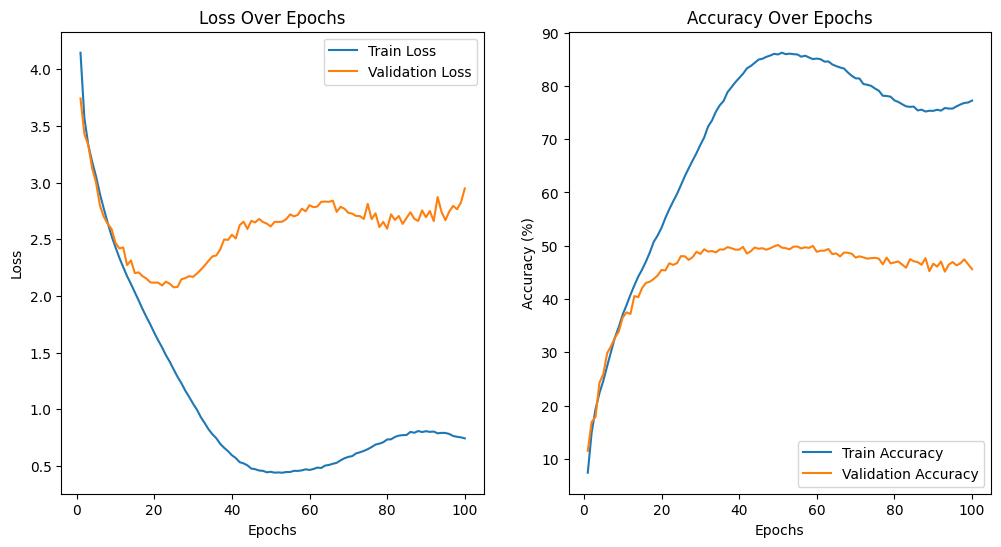

In [33]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()